In [13]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers

 Helper to extract emotion label + features

In [14]:
# Common label map
emotion_map = {
    'angry': 'angry',
    'calm': 'calm',
    'disgust': 'disgust',
    'fearful': 'fearful',
    'happy': 'happy',
    'neutral': 'neutral',
    'sad': 'sad',
    'surprised': 'surprised'
}

# Function to extract MFCC
def extract_features(file_path, sr=22050, n_mfcc=40):
    audio, sr = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T

def parse_ravdess(filename):
    emotion_code = filename.split('-')[2]
    emotion = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }.get(emotion_code)
    return emotion_map.get(emotion)

def parse_crema(filename):
    emotion_code = filename.split('_')[2]
    return emotion_map.get({
        'SAD': 'sad',
        'ANG': 'angry',
        'DIS': 'disgust',
        'FEA': 'fearful',
        'HAP': 'happy',
        'NEU': 'neutral'
    }.get(emotion_code))

def parse_tess(filename):
    emotion_code = filename.split('_')[-1].replace('.wav', '').lower()
    return emotion_map.get(emotion_code)

def parse_savee(filename):
    code = filename[:2] if filename.startswith('sa') or filename.startswith('su') else filename[0]
    return emotion_map.get({
        'a': 'angry',
        'd': 'disgust',
        'f': 'fearful',
        'h': 'happy',
        'n': 'neutral',
        'sa': 'sad',
        'su': 'surprised'
    }.get(code))


Extract data

In [15]:
# data_dir = "C:/Users/ANISH/Desktop/project 3/Ravdess"
def load_dataset(base_dir, parser):
    X, y = [], []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.wav'):
                path = os.path.join(root, file)
                label = parser(file)
                if label:
                    features = extract_features(path)
                    X.append(features)
                    y.append(label)
    return X, y

X, y = [], []

# Adjust paths to where you stored them
rav_X, rav_y = load_dataset("C:/Users/ANISH/Desktop/project 3/Speech Emotion Recognition/Ravdess", parse_ravdess)
crema_X, crema_y = load_dataset("C:/Users/ANISH/Desktop/project 3/Speech Emotion Recognition/Crema", parse_crema)
tess_X, tess_y = load_dataset("C:/Users/ANISH/Desktop/project 3/Speech Emotion Recognition/Tess", parse_tess)
savee_X, savee_y = load_dataset("C:/Users/ANISH/Desktop/project 3/Speech Emotion Recognition/Savee", parse_savee)

X.extend(rav_X + crema_X + tess_X + savee_X)
y.extend(rav_y + crema_y + tess_y + savee_y)


Encode labels + split data

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max([f.shape[0] for f in X])
X_padded = pad_sequences(X, maxlen=max_len, padding='post', dtype='float32')

le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, stratify=y_encoded)


Build model

In [17]:
model = models.Sequential([
    layers.Conv1D(64, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.MaxPooling1D(2),
    layers.LSTM(64),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


C:\Users\ANISH\tf_env_311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 224, 64)             │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 112, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 108, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 54, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,040 (422.03 KB)

 Trainable params: 108,040 (422.03 KB)

 Non-trainable params: 0 (0.00 B)

Train

In [18]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)
model.save("combined_audio_emotion_model.h5")

Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.2004 - loss: 1.9449 - val_accuracy: 0.3555 - val_loss: 1.6278
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.3514 - loss: 1.6353 - val_accuracy: 0.3316 - val_loss: 1.6244
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.3342 - loss: 1.6574 - val_accuracy: 0.4212 - val_loss: 1.4842
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.3939 - loss: 1.5359 - val_accuracy: 0.3886 - val_loss: 1.5577
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.3668 - loss: 1.5980 - val_accuracy: 0.4139 - val_loss: 1.4779
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.4173 - loss: 1.5037 - val_accuracy: 0.4070 - val_loss: 1.4908
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.4169 - loss: 1.4876 - val_accuracy: 0.4263 - val_loss: 1.4377
Epoch 8/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.4084 - loss: 1.4695 - 

Code for classification report + confusion matrix

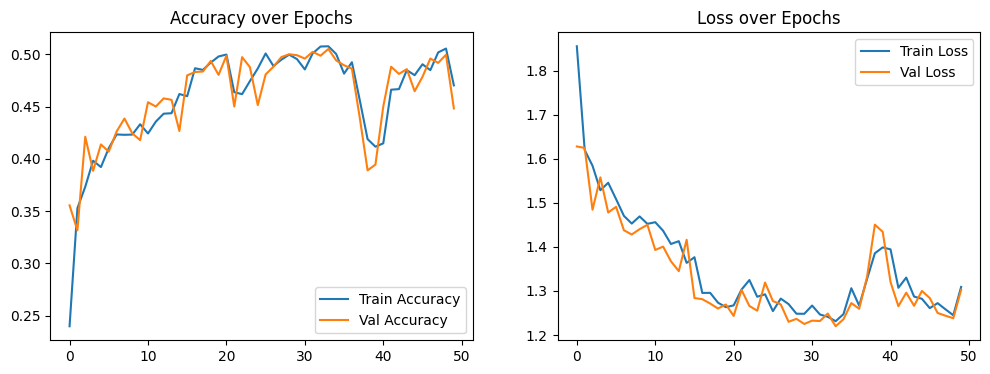

In [19]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
Classification Report:

              precision    recall  f1-score   support

       angry       0.62      0.64      0.63       373
        calm       0.37      0.82      0.51        38
     disgust       0.48      0.42      0.45       373
     fearful       0.30      0.04      0.07       292
       happy       0.47      0.44      0.46       373
     neutral       0.36      0.58      0.45       317
         sad       0.39      0.49      0.43       373
   surprised       0.41      0.24      0.30        38

    accuracy                           0.45      2177
   macro avg       0.43      0.46      0.41      2177
weighted avg       0.44      0.45      0.43      2177



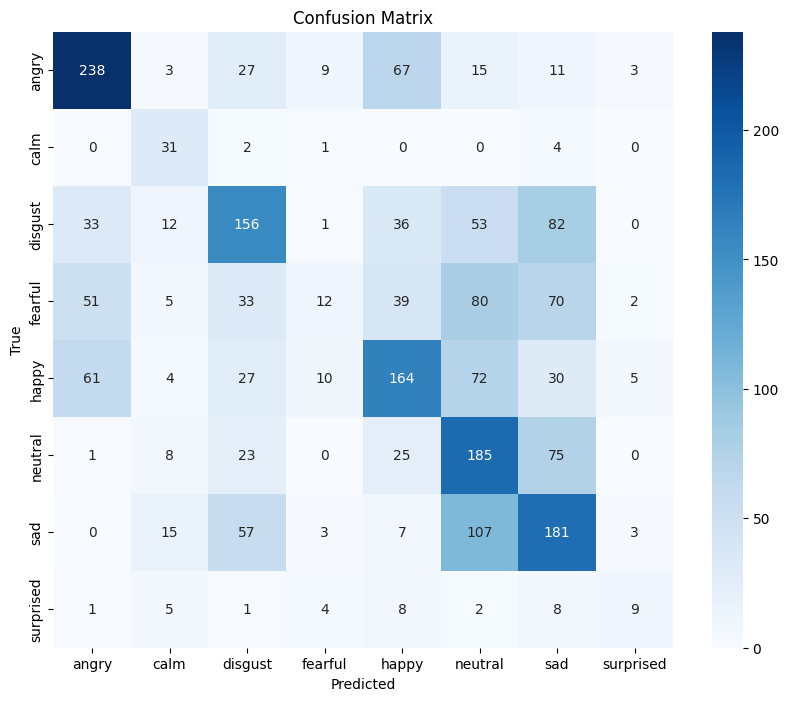

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
target_names = le.classes_
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
